In [1]:
import numpy as np
import math
from nmf import *
from sklearn.datasets import fetch_olivetti_faces
from scipy.stats import entropy
import matplotlib.pyplot as plt
import os

In [2]:
#izvor movielens skupa podataka - kaggle
#https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset/data
import pandas as pd
cols = ['user_id', 'item_id', 'rating', 'timestamp']
recenzije = pd.read_csv("ml-100k\\u.data", sep='\t', names=cols,header=None)
recenzije

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [4]:
user_ids = recenzije['user_id'].unique()
movie_ids = recenzije['item_id'].unique()

id_korisnika_u_idx = {u: i for i, u in enumerate(user_ids)} 
id_filma_u_idx = {m: i for i, m in enumerate(movie_ids)} 

n_users = len(user_ids)
n_movies = len(movie_ids)
print("br_korisnika:", n_users, "br_filmova:", n_movies)  # 943, 1682

br_korisnika: 943 br_filmova: 1682


In [5]:
X = np.zeros((n_users, n_movies), dtype=float)
#stvaram matricu podataka - recenzije za filmove (stupci) po korisnicima (retci)
for _, row in recenzije.iterrows():
    ui = id_korisnika_u_idx[row['user_id']]
    mi = id_filma_u_idx[row['item_id']]
    X[ui, mi] = row['rating']  # ocjene od 1 do 5

print("X.shape:", X.shape)
print("min, max:", X.min(), X.max())
X

X.shape: (943, 1682)
min, max: 0.0 5.0


array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 4., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
item_stupci = [
    'movie_id', 'title', 'release_date', 'video_release_date',
    'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation',
    "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

items = pd.read_csv(
    f"movies\\ml-100k\\u.item",
    sep='|',
    names=item_stupci,
    encoding='latin-1',  # da se maknu posebni znakovi
    header=None
)
items

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# naslovi filmova po stupcima od X ... da ih kasnije znam prepoznati
film_naslovi = np.empty(n_movies, dtype=object)

for _, row in items.iterrows():
    mid = row['movie_id']
    if mid in id_filma_u_idx:
        film_naslovi[id_filma_u_idx[mid]] = row['title']

# quick check
print(film_naslovi[:10])

['Kolya (1996)' 'L.A. Confidential (1997)' 'Heavyweights (1994)'
 'Legends of the Fall (1994)' 'Jackie Brown (1997)'
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'
 'Hunt for Red October, The (1990)' 'Jungle Book, The (1994)'
 'Grease (1978)' 'Remains of the Day, The (1993)']


In [8]:
#pocinjem s 30 komponenti - u izvodenju obicno se spusti na 17 komponenti
nmf = NMF(br_iter=200, br_komp=30, epsilon=1e-6)
nmf.Bayes(X, a=2.0)

print("W shape:", nmf.W.shape)
print("H shape:", nmf.H.shape)
print("Zavrsna relativna Frobeniusova greška:", nmf.residuali[-1])

W shape: (943, 17)
H shape: (17, 1682)
Zavrsna relativna Frobeniusova greška: 0.7252313026607635


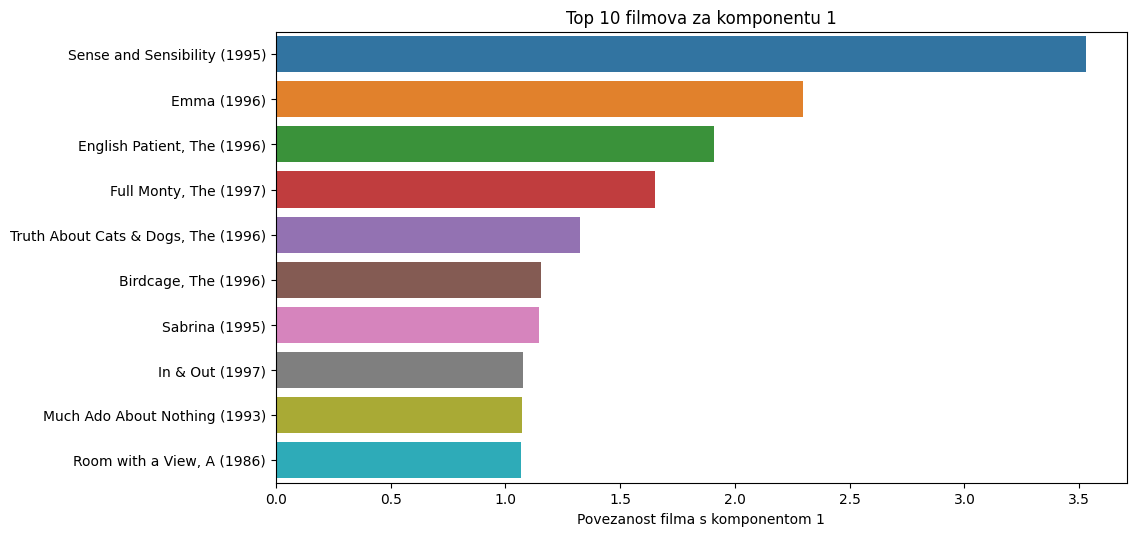

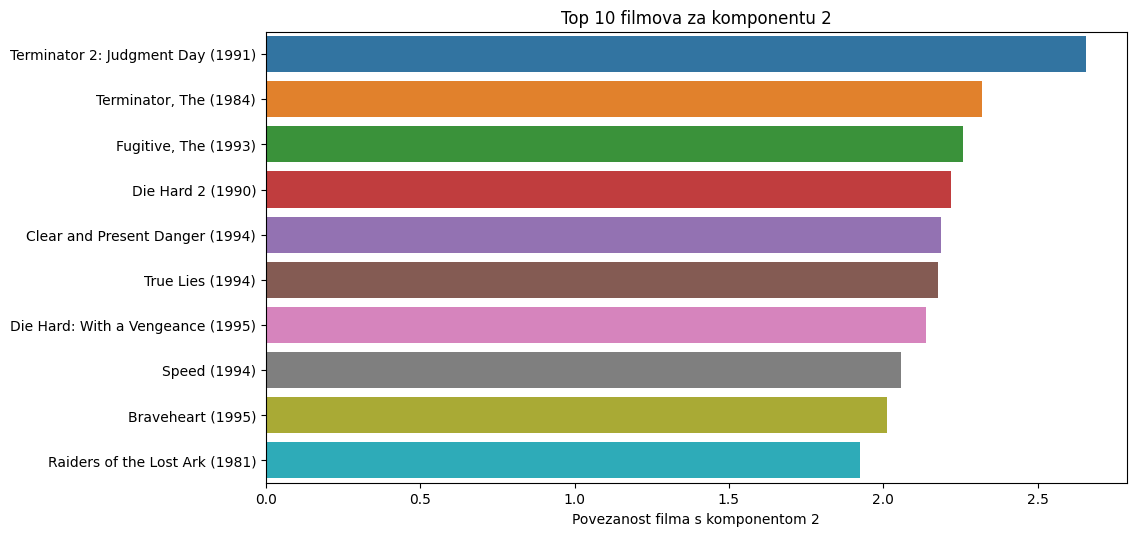

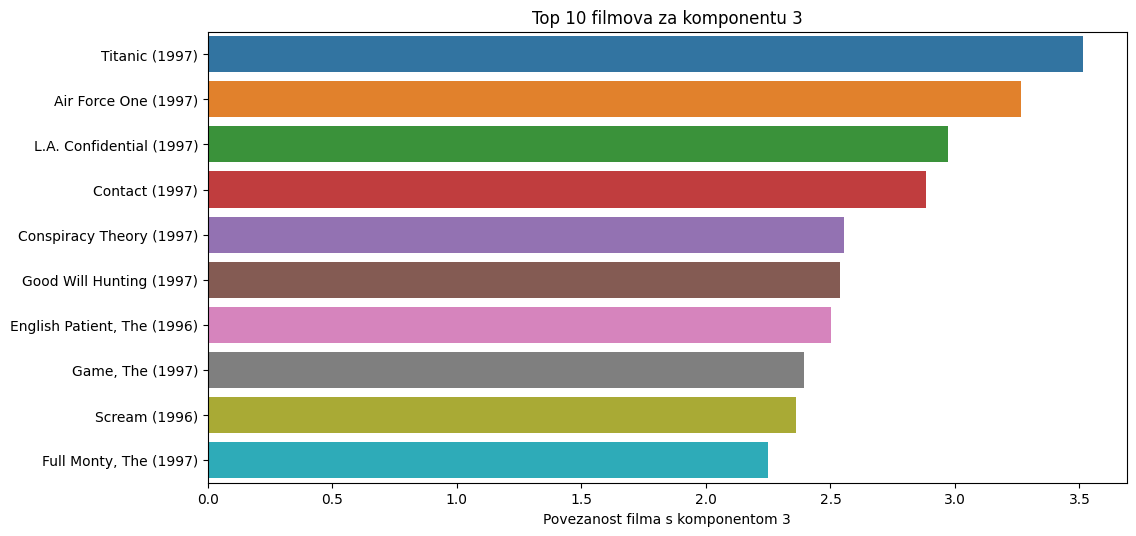

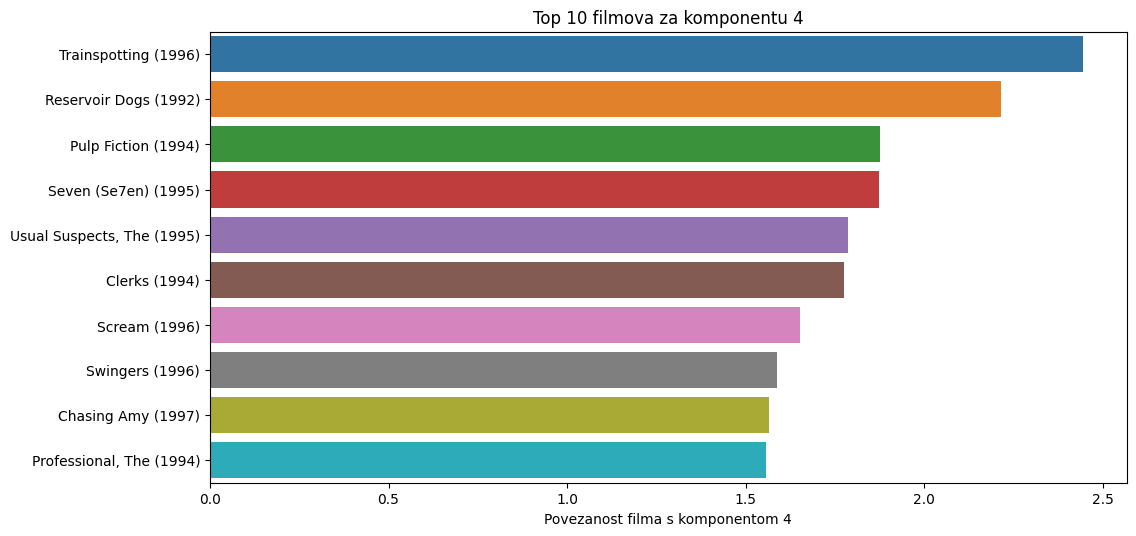

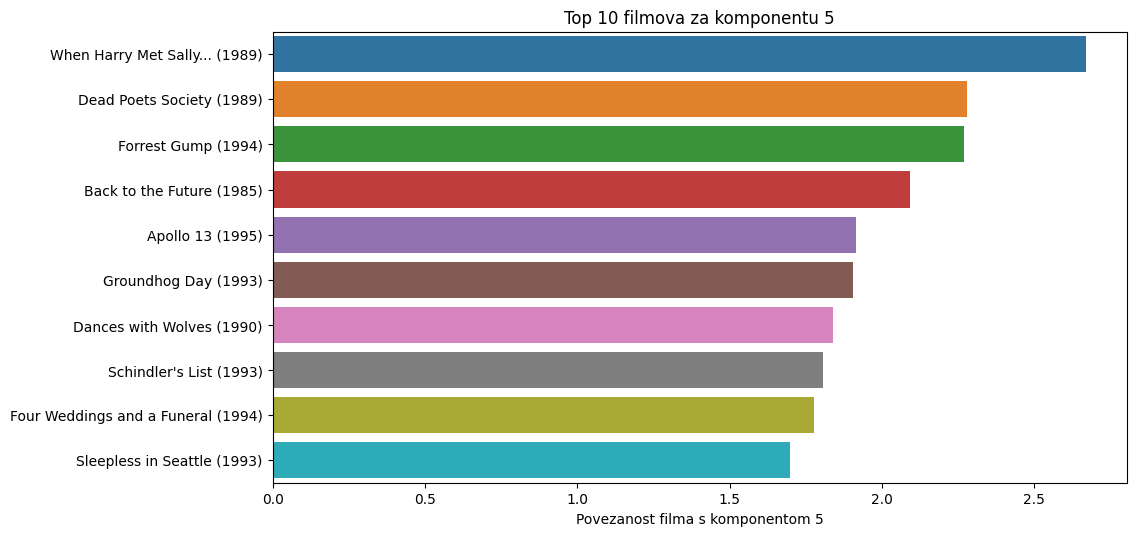

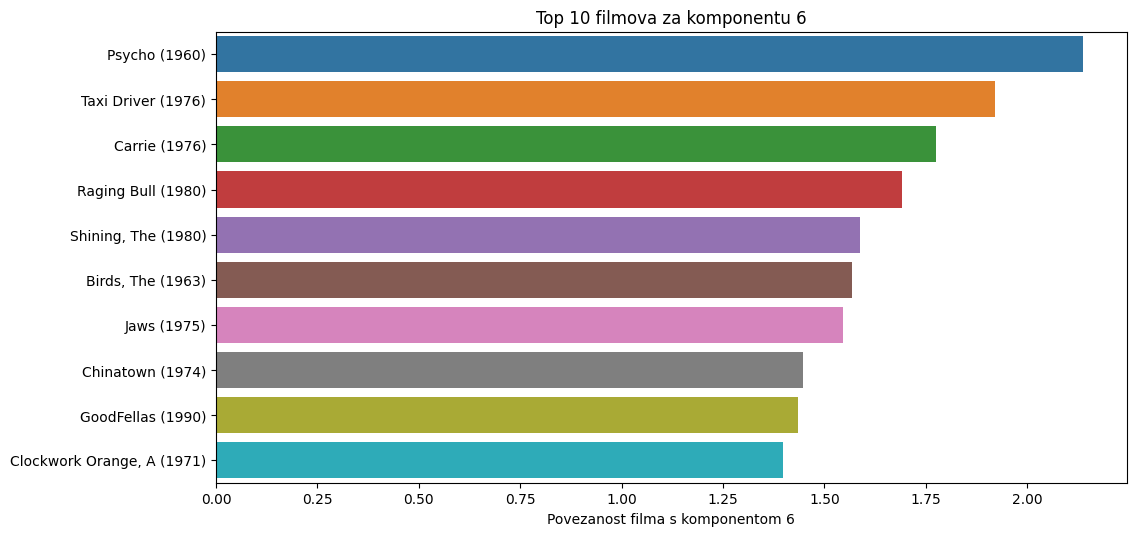

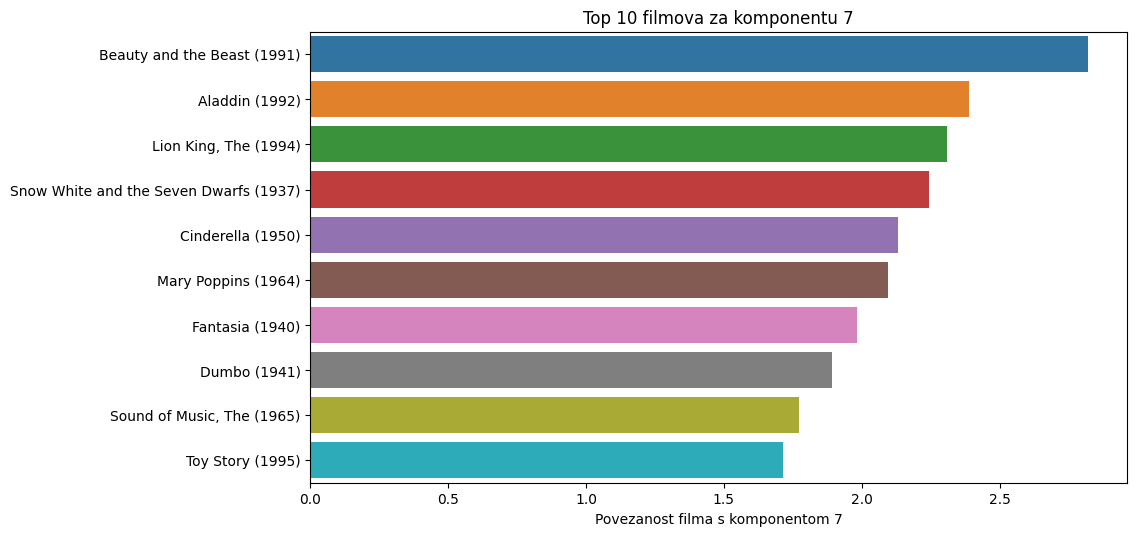

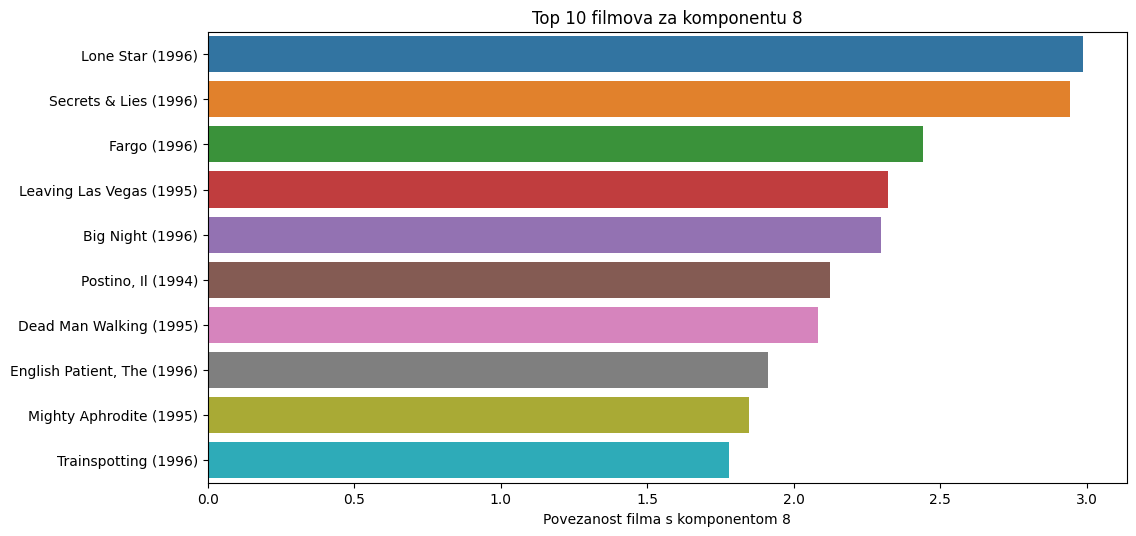

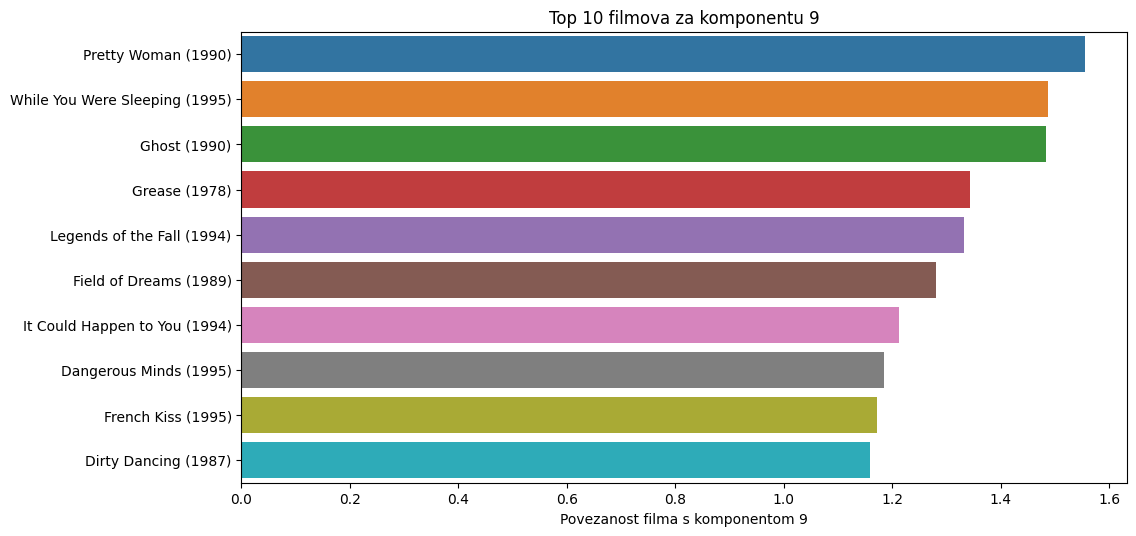

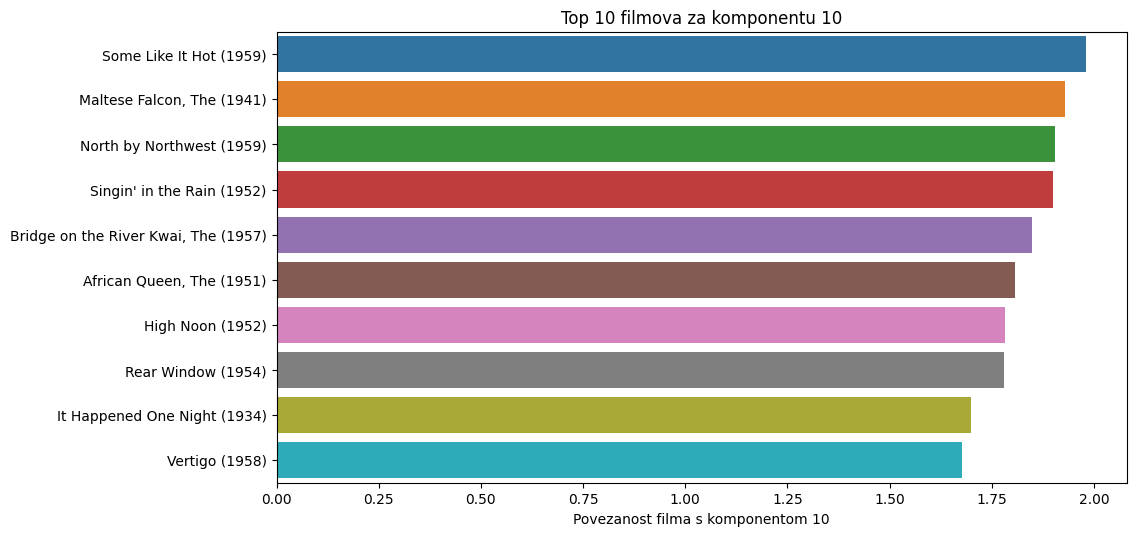

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#10 najznačajnijih filmova za prvih 10 komponenti
br_komp= 10
top_br = 10

for k in range(br_komp):
    top_filmovi_idx = nmf.H[k].argsort()[::-1][:top_br]
    top_filmovi = [film_naslovi[i] for i in top_filmovi_idx]
    top_znacaj = nmf.H[k, top_filmovi_idx]
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_znacaj, y=top_filmovi)
    plt.title(f"Top {top_br} filmova za komponentu {k+1}")
    plt.xlabel(f"Povezanost filma s komponentom {k+1}")
    plt.tight_layout(pad=3.0)
    #plt.savefig(f'plot{k}.png')
    plt.show()

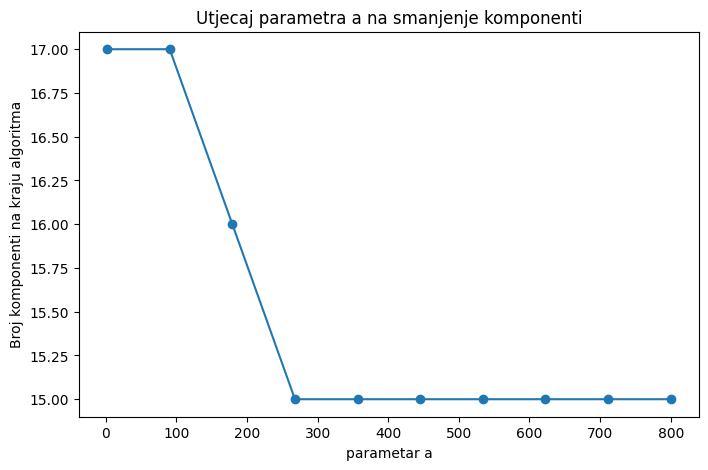

In [11]:
n = 1600
a_vrijednosti = np.linspace(2, n/2, 10)   
br_komp_final = []

for a in a_vrijednosti:
    nmf = NMF(br_iter=200, br_komp=30, epsilon=1e-6)
    nmf.Bayes(X, a=float(a))
    br_komp_final.append(nmf.W.shape[1])

# Plotting
plt.figure(figsize=(8,5))
plt.plot(a_vrijednosti, br_komp_final, marker='o')
plt.xlabel("parametar a")
plt.ylabel("Broj komponenti na kraju algoritma")
plt.title("Utjecaj parametra a na smanjenje komponenti")
plt.show()

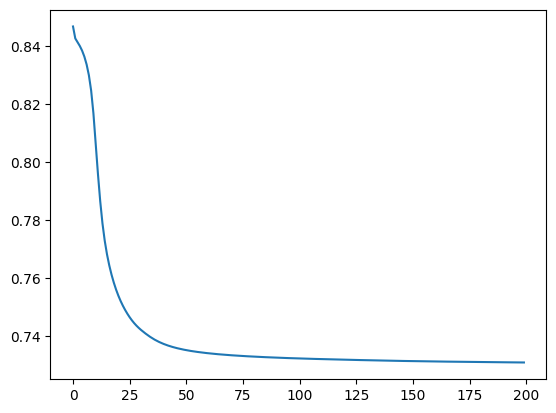

In [13]:
nmf.plot()

In [15]:
import numpy as np

u = 1  # ID korisnika (0-942)

ocjene_za_korisnika = nmf.W[u] @ nmf.H   #(vektor duljine 1682)

vec_ocijenjene = X[u] > 0
ocjene_bez_pogledanih = ocjene_za_korisnika.copy()
ocjene_bez_pogledanih[vec_ocijenjene] = -np.inf

top_indeksi = np.argsort(ocjene_bez_pogledanih)[-10:][::-1]
top_filmovi = [film_naslovi[i] for i in top_indeksi]
print("Top 10 predloženih dosad neocijenjenih filmova: ")
for rank, title in enumerate(top_filmovi, 1):
    print(f"{rank}. {title}")

Top 10 predloženih dosad neocijenjenih filmova: 
1. Eraser (1996)
2. Terminator 2: Judgment Day (1991)
3. Executive Decision (1996)
4. Titanic (1997)
5. Saint, The (1997)
6. Time to Kill, A (1996)
7. Phenomenon (1996)
8. Braveheart (1995)
9. Conspiracy Theory (1997)
10. Terminator, The (1984)


In [16]:
top_indeksi = np.argsort(X[u])[-10:][::-1]
top_filmovi = [film_naslovi[i] for i in top_indeksi]
print("Top 10 ocijenjenih filmova: ")
for rank, title in enumerate(top_filmovi, 1):
    print(f"{rank}. {title}")

Top 10 ocijenjenih filmova: 
1. Air Force One (1997)
2. Unforgettable (1996)
3. Murder at 1600 (1997)
4. Just Cause (1995)
5. Clear and Present Danger (1994)
6. Net, The (1995)
7. Client, The (1994)
8. Tombstone (1993)
9. Firm, The (1993)
10. Murder in the First (1995)
